In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# Define base directory
base_dir = '/content/drive/My Drive/reduced_dataset'

# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Normalize pixel values to [0, 1]
    rotation_range=20,        # Random rotation
    width_shift_range=0.2,    # Horizontal shift
    height_shift_range=0.2,   # Vertical shift
    horizontal_flip=True,     # Random horizontal flip
    zoom_range=0.2            # Random zoom
)

# Validation and test data generators (no augmentation, only normalization)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load training data
train_generator = train_datagen.flow_from_directory(
    f'{base_dir}/train',
    target_size=(224, 224),   # Resize images to 224x224
    batch_size=32,
    class_mode='binary',      # Binary classification (skin=1, non_skin=0)
    classes=['non_skin', 'skin'],  # Map folders to labels (0=non_skin, 1=skin)
    shuffle=False
)

# Load validation data
val_generator = val_datagen.flow_from_directory(
    f'{base_dir}/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    classes=['non_skin', 'skin'],
    shuffle=False
)

# Load test data
test_generator = test_datagen.flow_from_directory(
    f'{base_dir}/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    classes=['non_skin', 'skin'],
    shuffle=False
)

Found 700 images belonging to 2 classes.
Found 150 images belonging to 2 classes.
Found 150 images belonging to 2 classes.


In [ ]:
# Load pre-trained MobileNetV2 (excluding the top layers)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Add dropout to reduce overfitting
    Dense(1, activation='sigmoid')  # Binary output (0=non_skin, 1=skin)
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Summary of the model
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,  # Stop if no improvement after 5 epochs
    restore_best_weights=True
)

# Save the best model during training
checkpoint = ModelCheckpoint(
    '/content/drive/My Drive/skin_vs_nonskin_classifier.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

# Train the model
history = model.fit(
    train_generator,
    epochs=20,  # Start with 20 epochs, early stopping will halt if needed
    validation_data=val_generator,
    callbacks=[early_stopping, checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6456 - loss: 0.7584

22/22 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.6550 - loss: 0.7396 - val_accuracy: 1.0000 - val_loss: 0.0103
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 1.0000 - loss: 0.0086 - val_accuracy: 1.0000 - val_loss: 0.0028
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.9978 - loss: 0.0114 - val_accuracy: 1.0000 - val_loss: 0.0018
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 1.0000 - val_loss: 8.9254e-04


In [ ]:
from tensorflow.keras.models import load_model

best_model = load_model('/content/drive/My Drive/skin_vs_nonskin_classifier.h5')


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, generator, dataset_name):
    print(f"\n--- Evaluation on {dataset_name} Set ---")

    y_pred_prob = model.predict(generator)
    y_pred = (y_pred_prob > 0.5).astype("int32").flatten()
    y_true = generator.classes

    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc:.4f}")

    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=['non-skin', 'skin']))

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['non-skin', 'skin'],
                yticklabels=['non-skin', 'skin'])
    plt.title(f'{dataset_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()



--- Evaluation on Train Set ---
22/22 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step
Accuracy: 0.9986
Classification Report:
              precision    recall  f1-score   support

    non-skin       1.00      1.00      1.00       350
        skin       1.00      1.00      1.00       350

    accuracy                           1.00       700
   macro avg       1.00      1.00      1.00       700
weighted avg       1.00      1.00      1.00       700



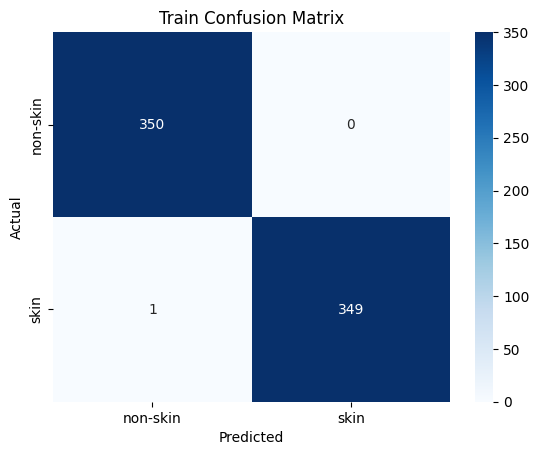


--- Evaluation on Validation Set ---
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step
Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

    non-skin       1.00      1.00      1.00        75
        skin       1.00      1.00      1.00        75

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



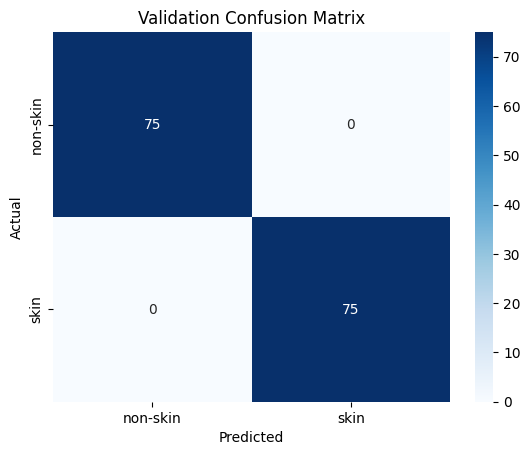


--- Evaluation on Test Set ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step
Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

    non-skin       1.00      1.00      1.00        75
        skin       1.00      1.00      1.00        75

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



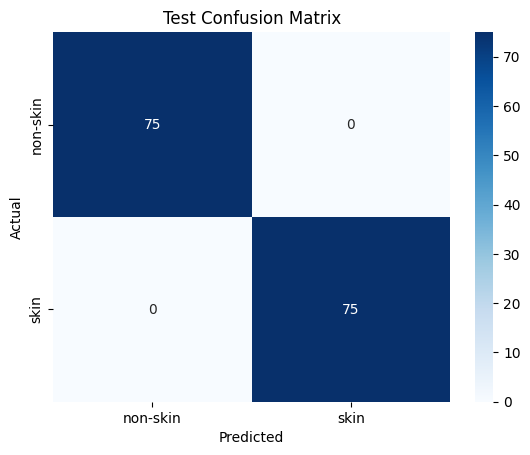

In [ ]:
evaluate_model(model, train_generator, "Train")
evaluate_model(model, val_generator, "Validation")
evaluate_model(model, test_generator, "Test")


In [ ]:
# Save the entire model in the Keras format
model.save('skin_vs_nonskin_classifier.h5')
